In [1]:
#libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#for log regression and ROC
import sklearn.metrics as metrics
from sklearn.linear_model import LogisticRegression as LogReg

#random forest
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
#this block is useless, just to have fancy graphs
import seaborn as sns
sns.set_style('dark')

In [2]:
DATASET = 'SambnisImp.csv'
docFull = pd.read_csv(DATASET)
#reduction to 91 variables + years + cow code
doc = docFull[["warstds", "year", "cowcode", "ager", "agexp", "anoc", "army85", "autch98", "auto4",
    "autonomy", "avgnabo", "centpol3", "coldwar", "decade1", "decade2",
    "decade3", "decade4", "dem", "dem4", "demch98", "dlang", "drel", "durable",
    "ef", "ef2", "ehet", "elfo", "elfo2", "etdo4590", "expgdp", "exrec",
    "fedpol3", "fuelexp", "gdpgrowth", "geo1", "geo2", "geo34", "geo57",
    "geo69", "geo8", "illiteracy", "incumb", "infant", "inst", "inst3", "life",
    "lmtnest", "ln_gdpen", "lpopns", "major", "manuexp", "milper", "mirps0",
    "mirps1", "mirps2", "mirps3", "nat_war", "ncontig", "nmgdp", "nmdp4_alt",
    "numlang", "nwstate", "oil", "p4mchg", "parcomp", "parreg", "part",
    "partfree", "plural", "plurrel", "pol4", "pol4m", "pol4sq", "polch98",
    "polcomp", "popdense", "presi", "pri", "proxregc", "ptime", "reg",
    "regd4_alt", "relfrac", "seceduc", "second", "semipol3", "sip2", "sxpnew",
    "sxpsq", "tnatwar", "trade", "warhist", "xconst"]]

2000

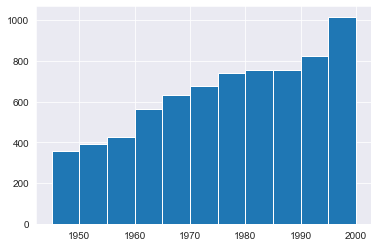

In [3]:
doc['year'].hist(bins=11)
doc['year'].max()

In [35]:
period = 10
vecy=np.arange(1945,2000,period)
tab = []
for year in vecy:
    tab.append( doc[ (doc['year'] >= year) & (doc['year'] < year+period) ] )
tab.append(doc[ doc['year'] >= 2000-55%period ])

7


In [5]:
def testRF( X , y , percent=0.25 ):

    clf = RandomForestClassifier(n_estimators=100)
    X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=percent)
    clf.fit(X_train,y_train)
    predictions = clf.predict_proba(X_test)[:,-1]
    n=0
    for i in range(len(predictions)):
        tmp= int(predictions[i]*2)-y_train[i]
        if(tmp!=0): 
            n+=1 
            
    return n/len(predictions)

def testLR( X , y , percent=0.25 ):
    lr = LogReg( penalty = 'none', solver='lbfgs', max_iter=1e9)
    X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=percent)
    lr.fit(X_train,y_train)
    predictions = lr.predict_proba(X_test)[:,-1]
    n=0
    for i in range(len(predictions)):
        tmp= int(predictions[i]*2)-y_train[i]
        if(tmp!=0): 
            n+=1 
            
    return n/len(predictions)

def rocRF( X , y , percent=0.25 ):
    clf = RandomForestClassifier(n_estimators=100, max_depth = 10)
    X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=percent)
    clf.fit(X_train,y_train)
    predictions = clf.predict_proba(X_test)[:,-1]
    falseRate, trueRate, threshold = metrics.roc_curve(y_test, predictions)
    auc = metrics.auc(falseRate, trueRate)
    auc = round(auc, 3)
    return falseRate , trueRate, auc
    

In [6]:
X = doc.drop(['warstds','year'] , axis='columns')
y = doc['warstds'].values

percentFalseRF = []
percentFalseLR = []

percentFalseRF.append(testRF(X,y,0.1))
percentFalseLR.append(testLR(X,y,0.1))

In [7]:
for df in tab:
    X = df.drop(['warstds','year'] , axis='columns')
    y = df['warstds'].values
    percentFalseRF.append(testRF(X,y,0.1))
    percentFalseLR.append(testLR(X,y,0.1))

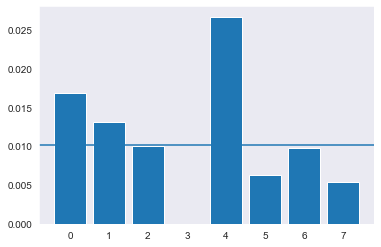

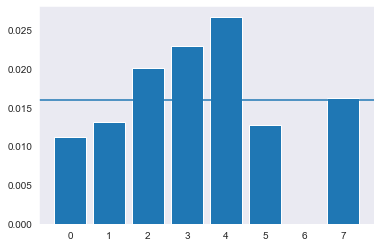

In [8]:
x= np.arange(0,len(percentFalseRF),1)

#random forest
plt.bar( x=x , height = percentFalseRF )
plt.axhline(y=np.mean(percentFalseRF[1:]))

#log reg
plt.figure()
plt.bar( x=x , height = percentFalseLR )
plt.axhline(y=np.mean(percentFalseLR[1:]))

[0.922, 0.941, 0.824, 0.814]
0.8596666666666666


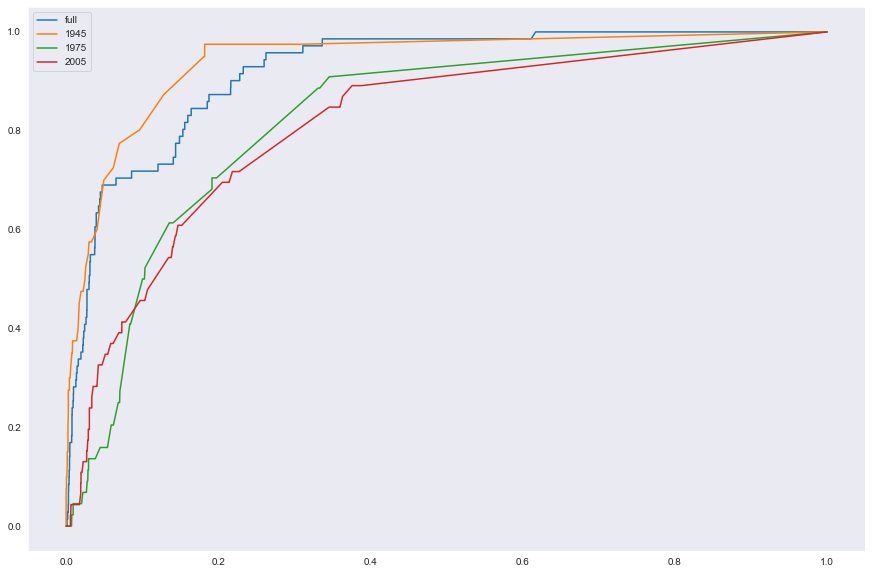

In [32]:
plt.figure(figsize=(15,10))

tabAUC=[]

X = doc.drop(['warstds','year'] , axis='columns')
y = doc['warstds'].values

falseRate , trueRate , auc = rocRF( X , y , 0.7  )
plt.plot(falseRate, trueRate, label = 'full'  )
tabAUC.append(auc)
year=1945
for df in tab:
    X = df.drop(['warstds','year'] , axis='columns')
    y = df['warstds'].values
    falseRate , trueRate , auc = rocRF( X , y , 0.7  )
    plt.plot(falseRate, trueRate, label = year  )
    tabAUC.append(auc)
    year+=period
plt.legend()

print(tabAUC)
print(np.nanmean(tabAUC[1:]))

(0, 200)

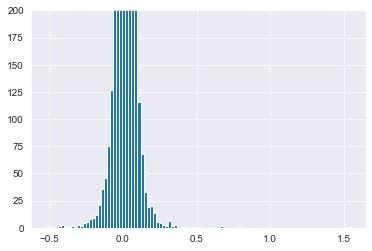

In [10]:
doc['gdpgrowth'].hist(bins=100)
plt.ylim([0,200])

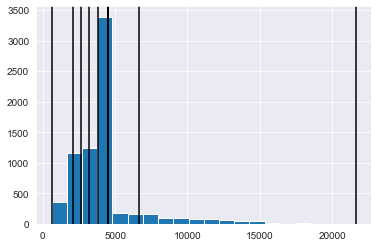

In [50]:
doc['nmgdp'].hist(bins=20)
quantile = docbis['nmgdp'].quantile(np.arange(0,1.1,0.1))
for q in quantile:
    plt.axvline(x=q,color='k')

In [53]:
docbis = doc.copy()
quantile = docbis['gdpgrowth'].quantile(np.arange(0,1.1,0.1))
tab=[]
for i in range(10):
    tab.append( doc[ (docbis['gdpgrowth'] >= quantile.iloc[i]) & (doc['gdpgrowth'] < quantile.iloc[i+1]) ] )

In [60]:
docbis = doc.copy()
quantile = docbis['nmgdp'].quantile(np.arange(0,1.2,0.2))
tab=[]
for i in range(10):
    tab.append( doc[ (docbis['nmgdp'] >= quantile.iloc[i]) & (doc['nmgdp'] < quantile.iloc[i+1]) ] )

IndexError: single positional indexer is out-of-bounds

C:\anaconda\lib\site-packages\sklearn\metrics\_ranking.py:808: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


[0.721, 0.574, 0.704, 0.672, 0.5, nan, 0.884, 0.543, 0.477, 0.5]
0.6194444444444445


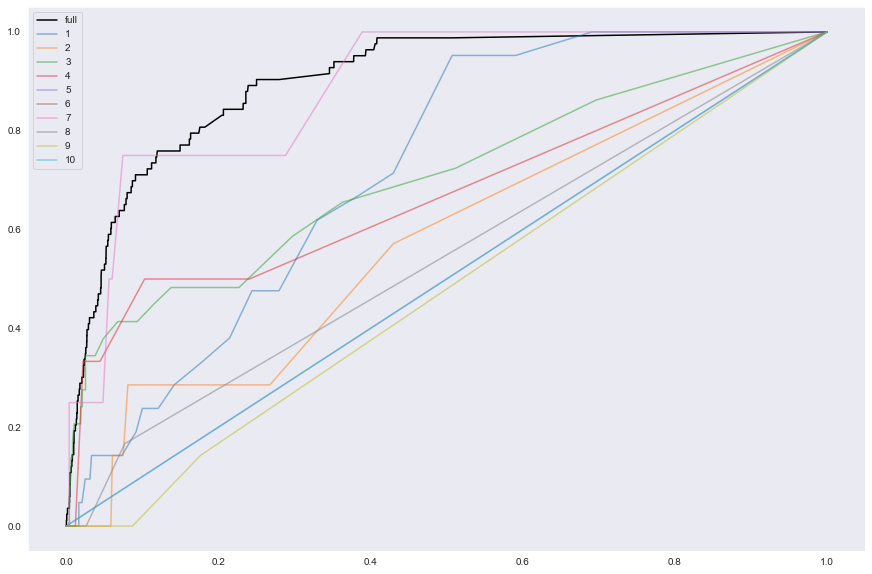

In [52]:
plt.figure(figsize=(15,10))

tabAUC=[]

X = doc.drop(['warstds','year','gdpgrowth'] , axis='columns')
y = doc['warstds'].values

falseRate , trueRate , auc = rocRF( X , y , 0.7  )
plt.plot(falseRate, trueRate, label = 'full' , color = 'k' )
tabAUC.append(auc)

qt=1

for df in tab:
    X = df.drop(['warstds','year'] , axis='columns')
    y = df['warstds'].values
    falseRate , trueRate , auc = rocRF( X , y , 0.7  )
    plt.plot(falseRate, trueRate, label = qt , alpha = 0.5)
    tabAUC.append(auc)
    qt+=1
    #print( df['gdpgrowth'].var() )
plt.legend()

print(tabAUC[1:])
print(np.nanmean(tabAUC[1:]))

C:\anaconda\lib\site-packages\sklearn\metrics\_ranking.py:808: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


0.795
0.59175


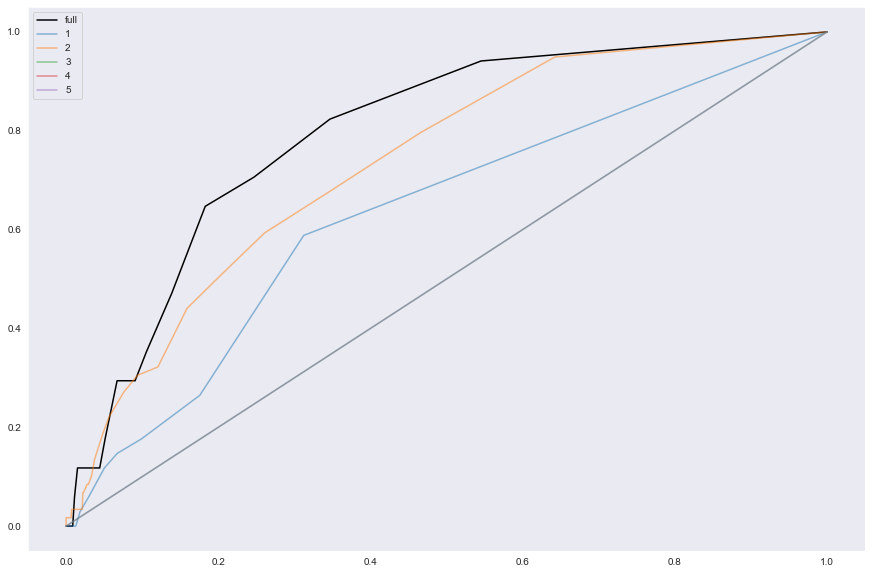

In [75]:
plt.figure(figsize=(15,10))

tabAUC=[]

doctmp = doc.sample(frac=0.2)

X = doctmp.drop(['warstds','year'] , axis='columns')
y = doctmp['warstds'].values

falseRate , trueRate , auc = rocRF( X , y , 0.9  )
plt.plot(falseRate, trueRate, label = 'full' , color = 'k' )
tabAUC.append(auc)

qt=1

for df in tab:
    X = df.drop(['warstds','year'] , axis='columns')
    y = df['warstds'].values
    falseRate , trueRate , auc = rocRF( X , y , 0.9  )
    plt.plot(falseRate, trueRate, label = qt , alpha = 0.5)
    tabAUC.append(auc)
    qt+=1
plt.legend()

print(tabAUC[0])
print(np.nanmean(tabAUC[1:]))

In [3]:
#test nmgdp == gdp per capita
cow = docFull['cowcode'].unique()

relative=[0]*len(docFull)
for country in cow:
    tmp = docFull[ docFull['cowcode']==country ].sort_values(by='year')
    for year in tmp['year'].unique()[1:]:
        before = tmp[ tmp['year'] == year-1 ]['nmgdp'].values[0]
        after = tmp[ tmp['year'] == year ]['nmgdp'].values[0]
        ratio = (after-before)/before 
        ind=docFull.loc[ (docFull['year'] == year) & (docFull['cowcode'] == country) ].index.values[0] 
        relative[ind]=ratio
docFull['evolnmgdp'] = relative

<Figure size 1080x720 with 0 Axes>

In [29]:
#create a column of the evolution of a feature (must be numbers) by country, year to year
#return vector of this evolution --> df['feature']= computeEvol(df,feature)
#needs the column 'year' & 'cowcode'
def computeEvol(df,feature):
    cow = df['cowcode'].unique()
    relative=[0]*len(df)
    for country in cow:
        tabCountry = df[ df['cowcode']==country ].sort_values(by='year')
        for year in tabCountry['year'].unique()[1:]:
            before = tabCountry[ tabCountry['year'] == year-1 ][feature].values[0]
            after = tabCountry[ tabCountry['year'] == year ][feature].values[0]
            ratio = (after-before)/before 
            ind=df.loc[ (df['year'] == year) & (df['cowcode'] == country) ].index.values[0] 
            relative[ind]=ratio
    return relative

In [30]:
docFull['evolnmgdp'] = computeEvol(docFull,'nmgdp')

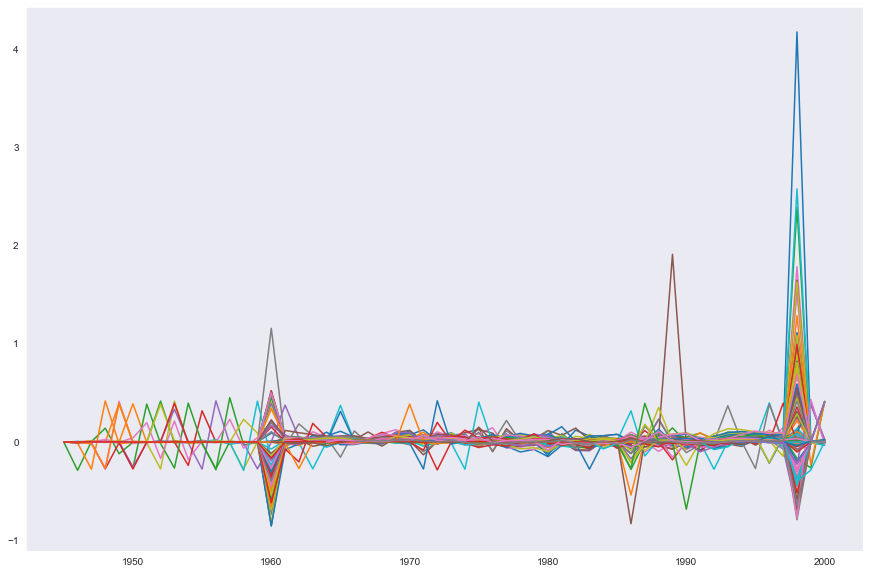

In [31]:
plt.figure(figsize=(15,10))
for country in cow:
    tmp = docFull[ docFull['cowcode']==country ].sort_values(by='year')
    plt.plot( tmp['year'] , tmp['evolnmgdp'])

In [80]:
print( docFull['evolnmgdp'].values )

[ 0.00000000e+00 -3.72468800e-03 -1.57472414e-03 ...  4.13711885e-01
  6.05742701e-03 -9.36455026e-05]


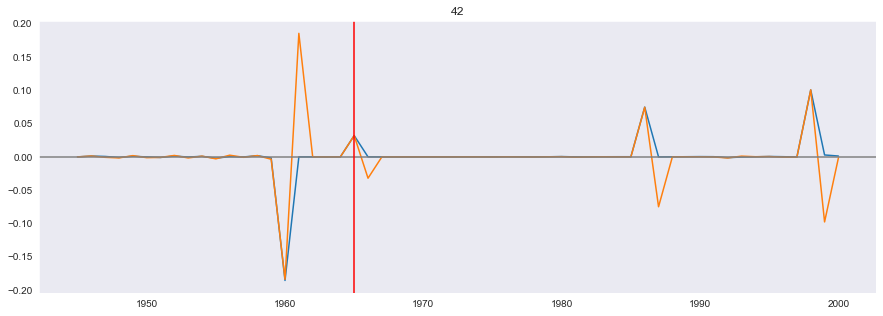

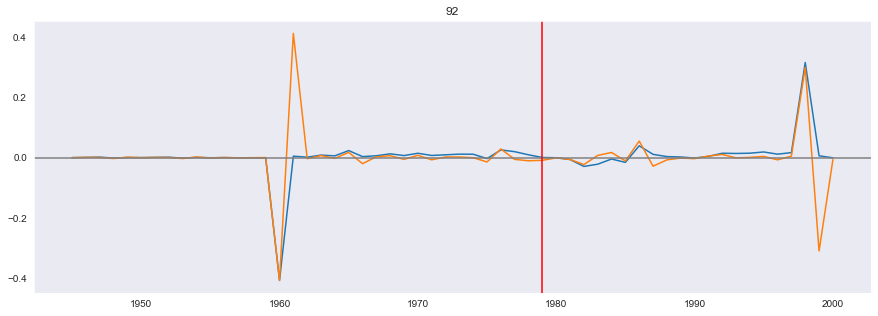

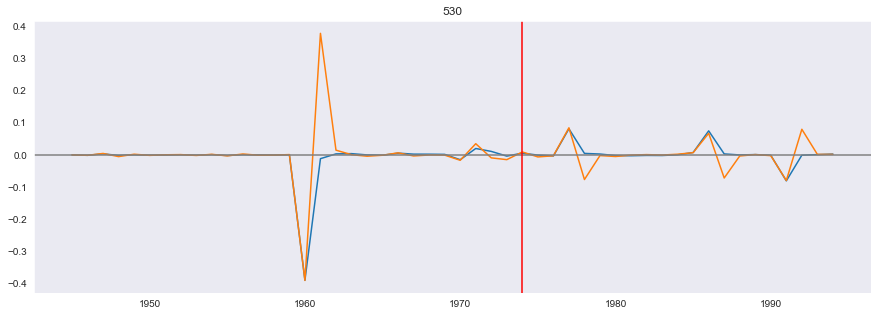

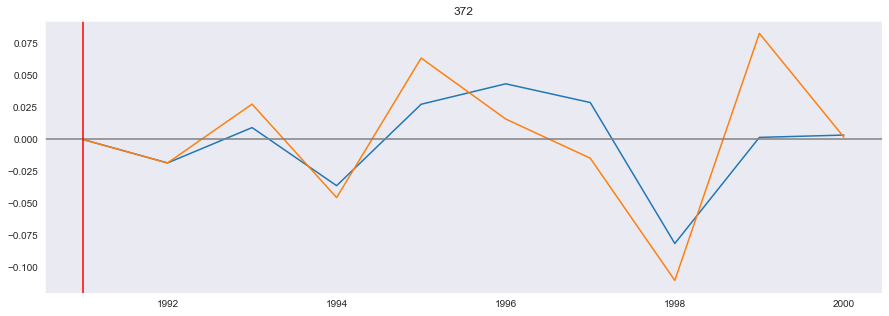

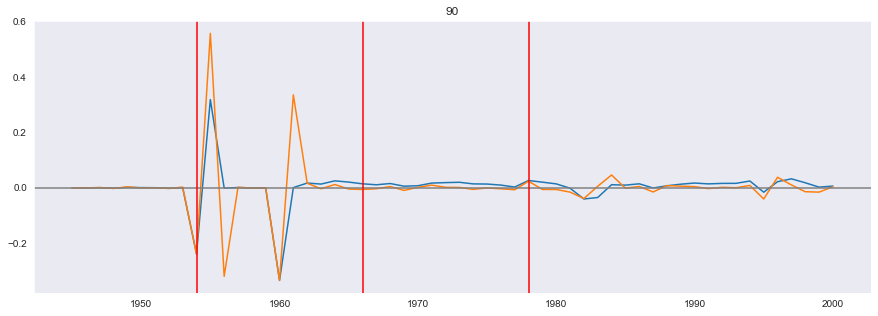

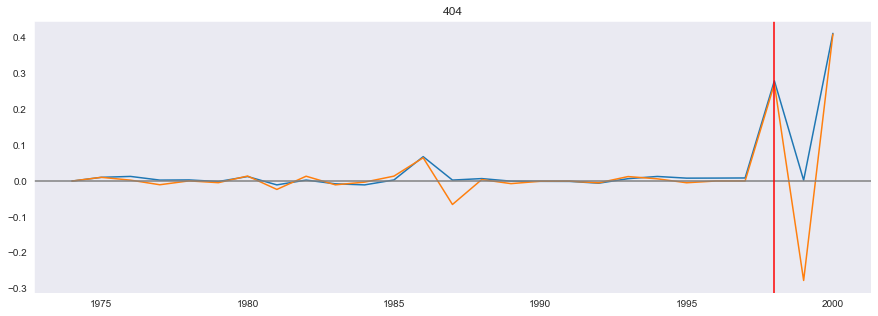

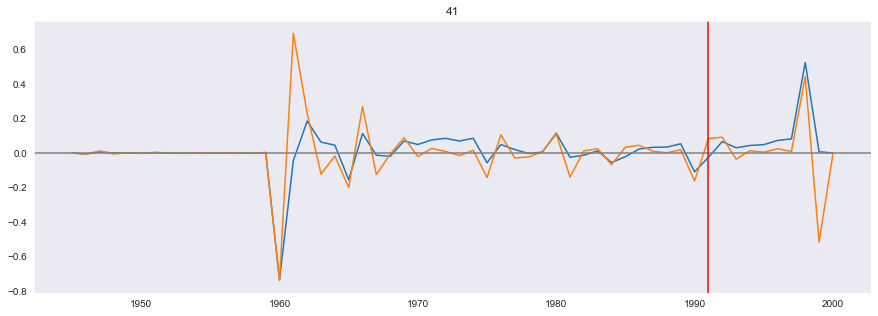

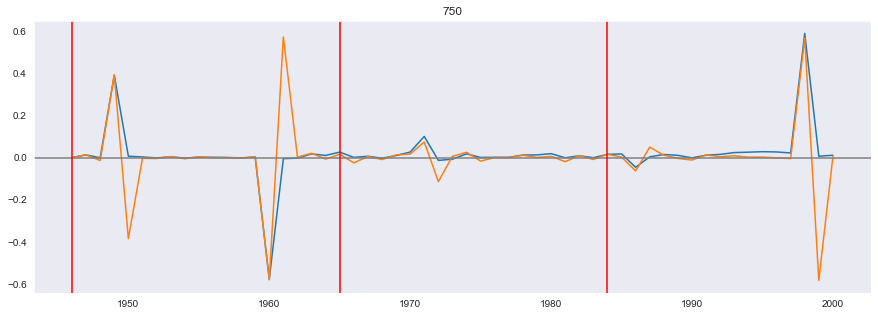

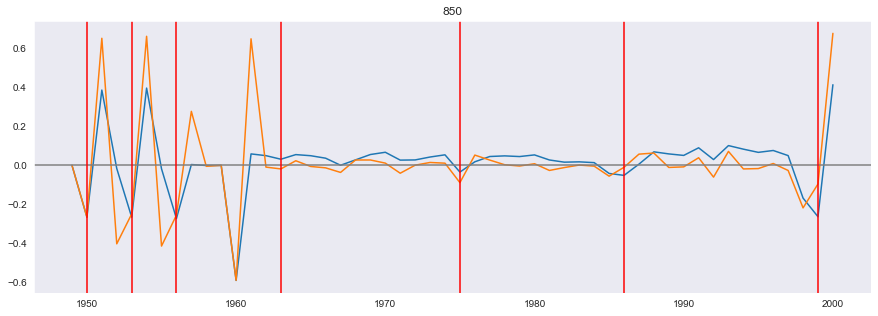

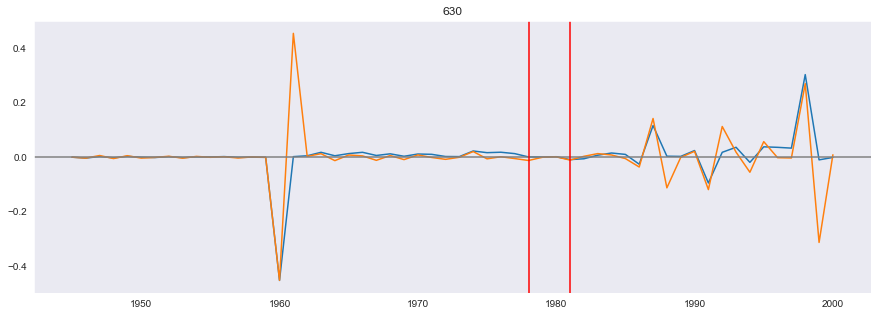

In [41]:
listCountry=docFull[docFull['warstds']==1]['cowcode'].unique()[20:30]

reduced = docFull[ docFull['cowcode'].isin(listCountry) ]

for country in reduced['cowcode'].unique():
    tmp = reduced[ reduced['cowcode']==country ].sort_values(by='year')
    plt.figure(figsize=(15,5))
    plt.plot( tmp['year'] , tmp['evolnmgdp'])
    
    #test culumulation nc
    '''nc=2
    testvec=[0]*nc
    for i in range(nc,len(tmp)):
        testvec.append( sum( tmp['evolnmgdp'].values[i-nc:i] ) )
    plt.plot( tmp['year'] ,testvec)'''
    
    testvec=[0]
    for i in range(1,len(tmp)):
        testvec.append( tmp['evolnmgdp'].values[i]-tmp['evolnmgdp'].values[i-1]  )
    plt.plot( tmp['year'] ,testvec)
    
    plt.title(country)
    plt.axhline(y=0,color='grey')
    #plot the year with a civil war
    for index, row in tmp.iterrows():
        if( row['warstds']==1 ):
            plt.axvline(x=row['year'],color='r')


In [55]:
ft='infant'
docFull['evol'+ft] = computeEvol(docFull,ft)

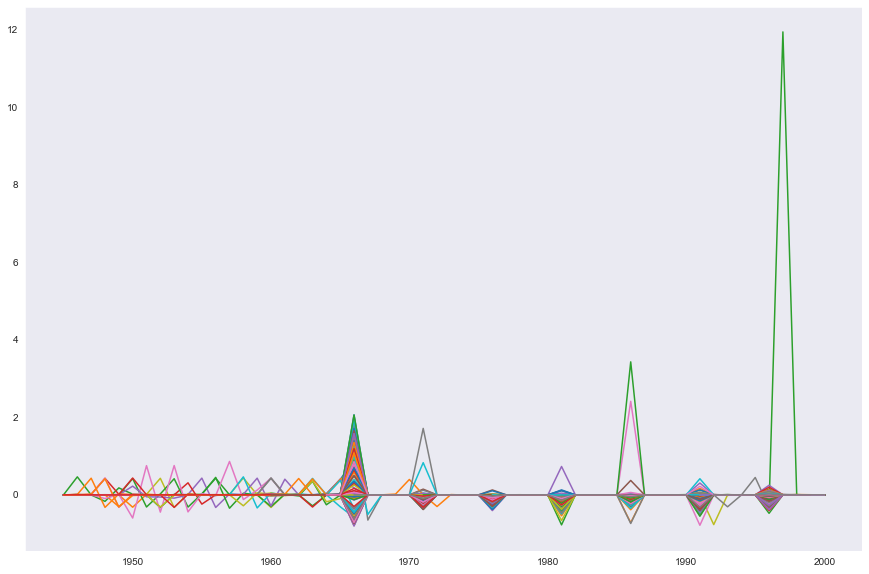

In [56]:

plt.figure(figsize=(15,10))
for country in cow:
    tmp = docFull[ docFull['cowcode']==country ].sort_values(by='year')
    plt.plot( tmp['year'] , tmp['evol'+ft])

infant


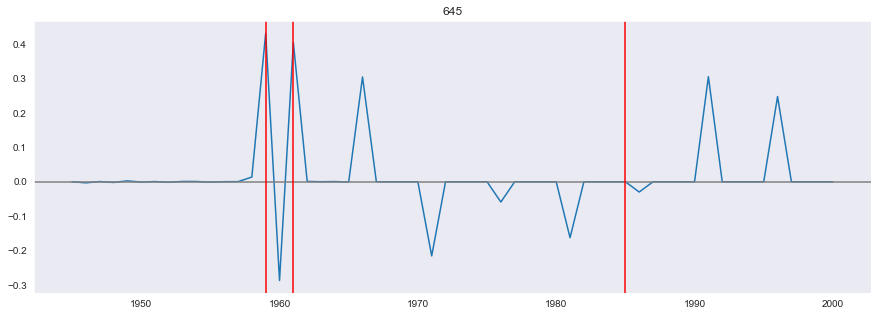

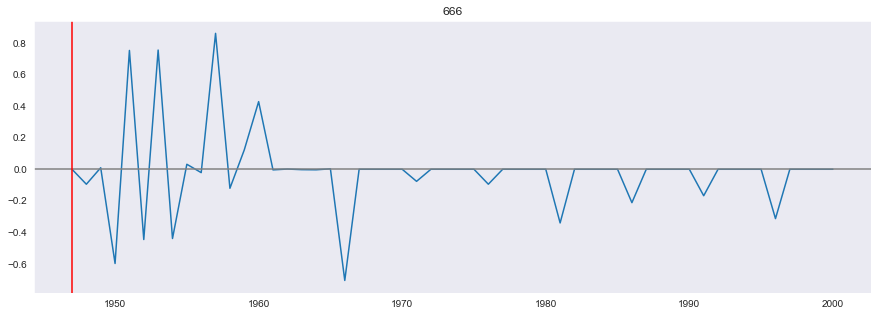

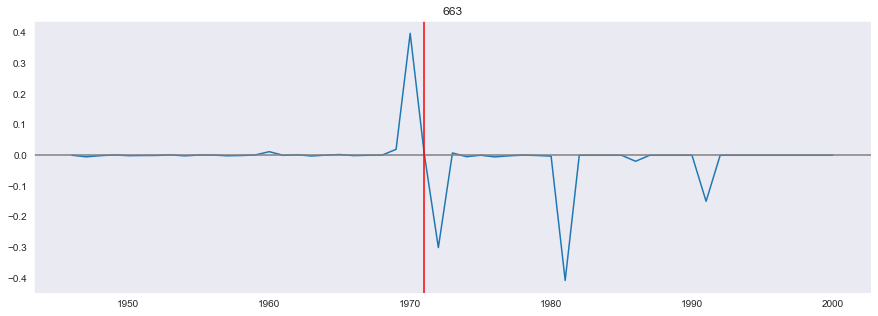

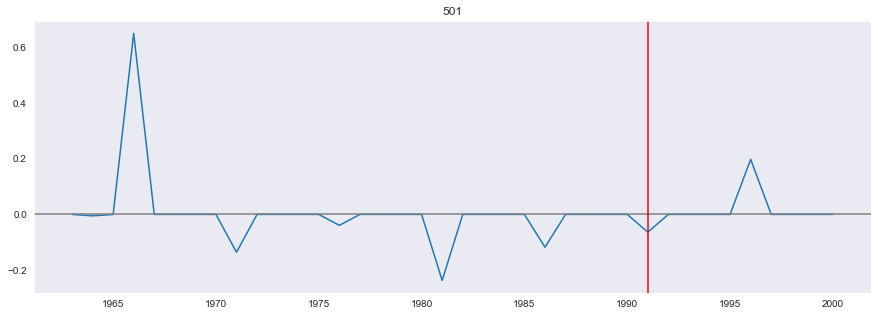

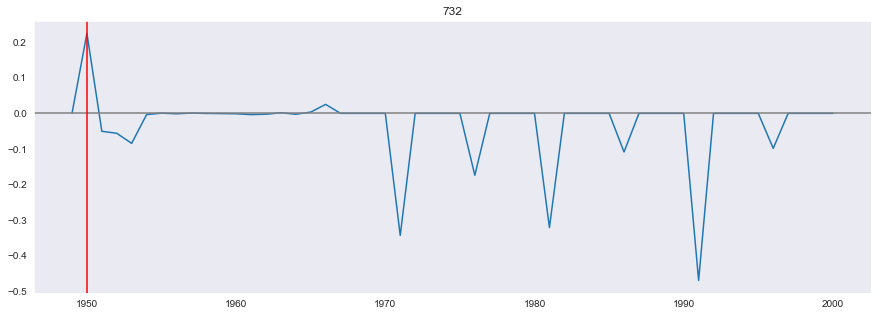

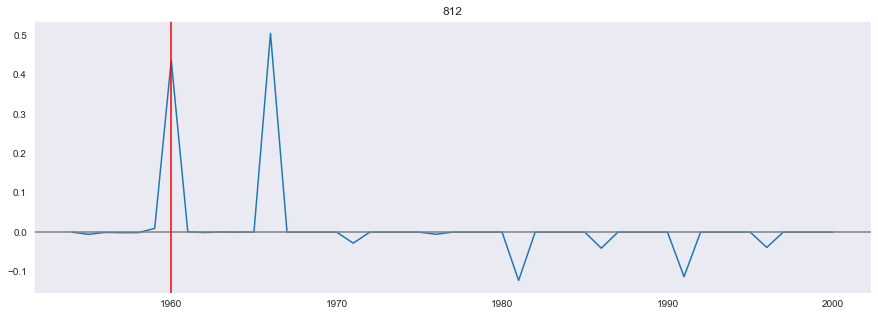

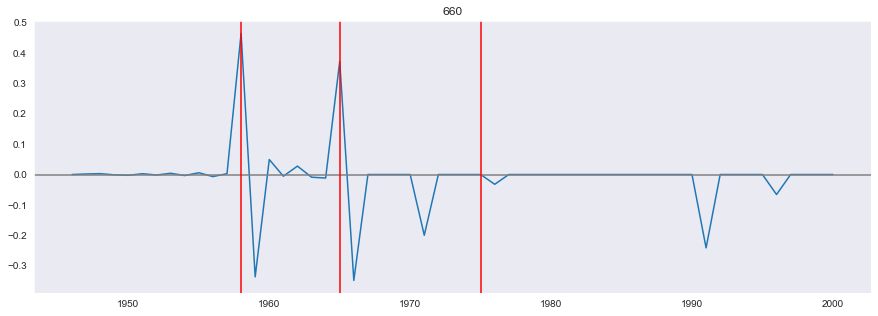

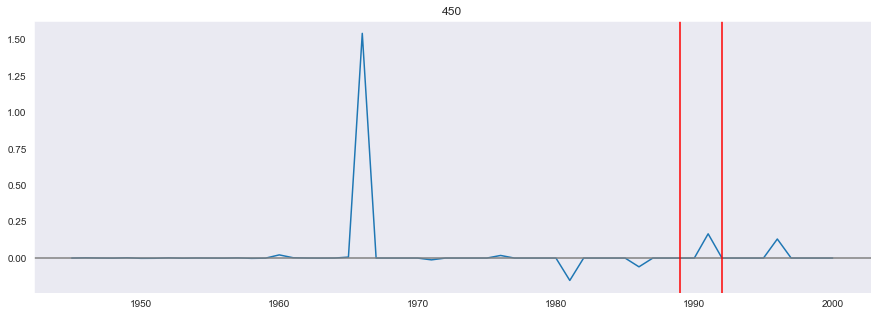

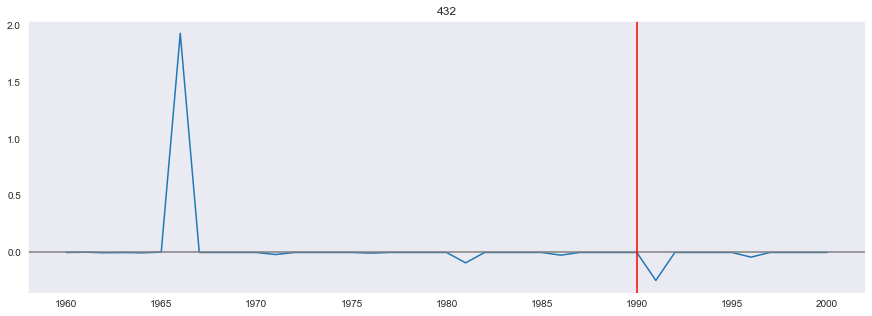

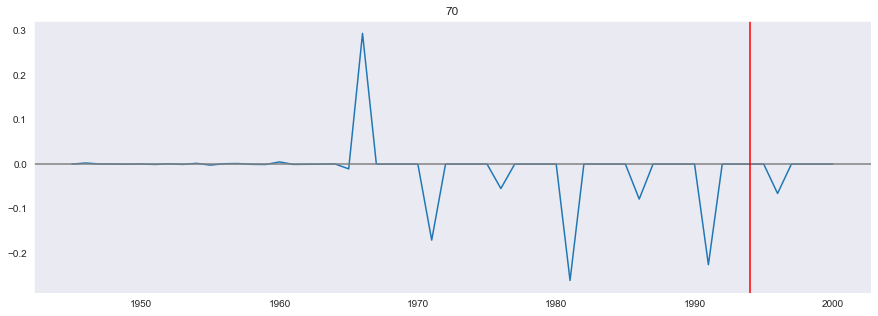

In [57]:
listCountry=docFull[docFull['warstds']==1]['cowcode'].unique()[30:40]

reduced = docFull[ docFull['cowcode'].isin(listCountry) ]
print(ft)
for country in reduced['cowcode'].unique():
    tmp = reduced[ reduced['cowcode']==country ].sort_values(by='year')
    plt.figure(figsize=(15,5))
    plt.plot( tmp['year'] , tmp['evol'+ft])
    plt.title(country)
    plt.axhline(y=0,color='grey')
    #plot the year with a civil war
    for index, row in tmp.iterrows():
        if( row['warstds']==1 ):
            plt.axvline(x=row['year'],color='r')
